# Analyze the tree-guided MTL results on the EndoMT data produced in Frankfurt (data imputed)

## TFs involved in the TGF-beta pathway or its mediation
This article provides a review on the TGF-beta ... https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3606489/
It focuses on how MAPK activity modulates the function of TGF-beta/BMP. Therefore, I looked up for the direct DNA binding TFs that involve in the MAFK pathway and found MYC abd CREB.

Also it seems that TGF-beta is mediated through the TFs SMAD2/3. However, according to [this study](http://genesdev.cshlp.org/content/19/23/2783.long), SMAD2/3 have very low binding affinities to the DNA and they require other factors/elements in order to form stable complexes.

The purpose of this analysis is to study the role of transcription factors (TFs) measured in vitro (TEPIC- TF binding affinities) in deriving the gene expession in single cells of two  cell types. We expect the statistical model to select distinct sets of TFs for each cell type.

## Data
The data to be used for training the tree-guided MTL model:

### Features
Promoter: he binding affinity of ~700 TFs are estimated in a 2kb window around the TSSof each gene (mapped against genome hg38)

### Responses
   * The response **matrix** here is essentially the gene expression matrix for the EndoMT cells (hg38).
   * scImpute was run on the entire gene expression with the k parameter (indicating the num of cell types) to 2 to address the drop-out issue.
   * The imputed read counts are then converted to TPM values using my compute_TPM.R script.

## Filtering
### Based on gene expression variance
The genes showing small variance in their expression across the single cells are removed from the data.
### Based on TF expression
The TFs that their corresponding genes are not expressed in more than 90% of the cells are removed as well.

## Model fitting
* Partitioned 60% of the data for training and 40% for test
* Data is normalized with zero mean and unit variance
* 5-fold CV is used to select the model with best average CV error.
* 21 lambda values are explored during the CV prodecure.
* Maximum number of iterations is limitted to 200

The fitted model together with the partitioned data are stored in an RData object that can be loaded.

## Load the model trained on imputed data

In [1]:
load("../../scMTL_EndoMT_imputed_static_TGGLasso.RData")

## Log-transfer and normalize the partitioned data
The stored partitioned data in the above RData object is in the original space. In order to proceed with the downstream analysis, it's easier to normalize them in the same way they were done before model fitting.

In [2]:
x.train <- scale(log2(1 + partition$train$x))
y.train <- scale(log2(1 + partition$train$y))


x.test <- scale(log2(1 + partition$test$x), center= colMeans(log2(1 + partition$train$x)),
                scale= apply(log2(1 + partition$train$x), 2, FUN= sd))
y.test <- scale(log2(1 + partition$test$y), center= colMeans(log2(1 + partition$train$y)),
                scale= apply(log2(1 + partition$train$y), 2, FUN= sd))

## Train and test dimenstion

In [3]:
print("train:")
print(dim(x.train))
print("test:")
print(dim(x.test))

[1] "train:"
[1] 2774  726
[1] "test:"
[1] 1850  726


## Cell names

In [4]:
head(colnames(y.train))

[1] "AAACCTGGTTACCAGT.1" "AAACCTGTCCCAGGTG.1" "AAACCTGTCTCAACTT.1"
[4] "AAACGGGGTGACCAAG.1" "AAAGATGCATTCACTT.1" "AAAGATGTCGTACCGG.1"

## PCA applied on training and test features
Unfortunately this part does not work for this dataset, since we have more features than samples (more TFs than genes)

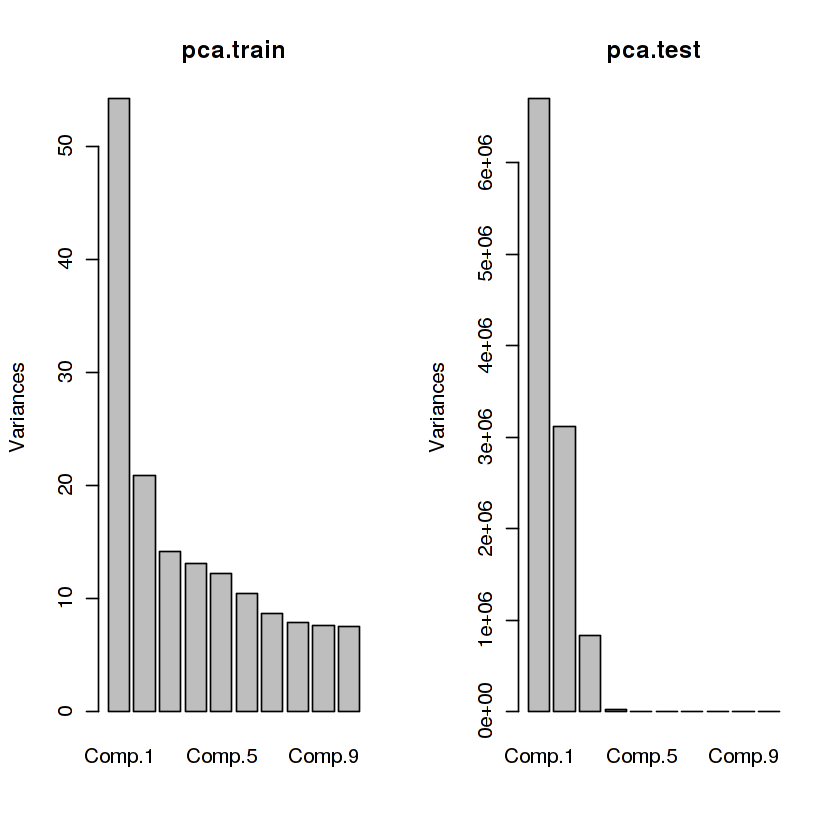

In [5]:
doPCA <- TRUE
if(doPCA){
    pca.train <- princomp(x.train)
    pca.test <- princomp(x.test)
    par(mfrow= c(1, 2))
    plot(pca.train)
    plot(pca.test)
}

## Compute the predictions on training and test data

In [6]:
pred.train <- cbind(1, x.train) %*% rbind(TGL.model$intercept, TGL.model$B)
pred.test <- cbind(1, x.test) %*% rbind(TGL.model$intercept, TGL.model$B)

### Plot the scatter plots for some random cells (training data)

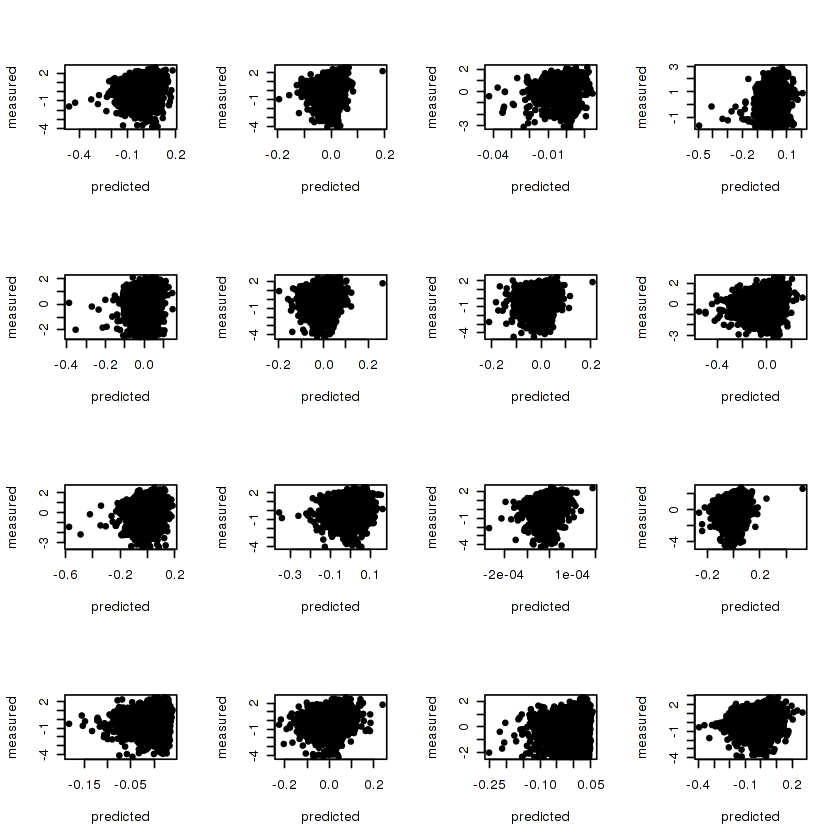

In [7]:
n <- 16
par(mfrow = c(sqrt(n), sqrt(n)))

random.idx <- sample(ncol(pred.train))[seq(n)]
for(i in seq(n))
    plot(pred.train[, random.idx[i]], y.train[, random.idx[i]], pch= 20, xlab= "predicted", ylab= "measured")

### Plot the scatter plots for some random cells (test data)

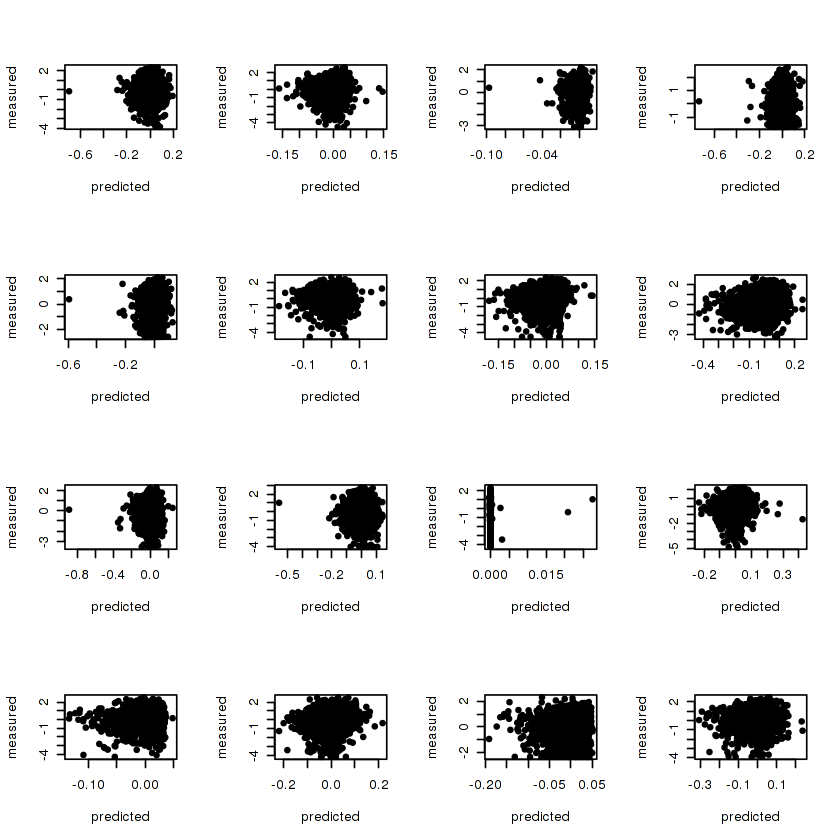

In [8]:
#n <- 25
par(mfrow = c(sqrt(n), sqrt(n)))

#random.idx <- sample(ncol(pred.test))[seq(n)]
for(i in seq(n))
    plot(pred.test[, random.idx[i]], y.test[, random.idx[i]], pch= 20, xlab= "predicted", ylab= "measured")

## Compute the correlations between predicted and actual measurements of gene expression

In [9]:
options(warn= -1)
# Train
## Method= Pearson
cors.train.p <- sapply(seq(ncol(pred.train)), function(i)
    cor(pred.train[, i], y.train[, i], method= "pearson"))

## Method= Spearman
cors.train.s <- sapply(seq(ncol(pred.train)), function(i)
    cor(pred.train[, i], y.train[, i], method= "spearman"))
                      
# Test
## Method= Pearson
cors.test.p <- sapply(seq(ncol(pred.test)), function(i)
    cor(pred.test[, i], y.test[, i], method= "pearson"))

## Method= Spearman
cors.test.s <- sapply(seq(ncol(pred.test)), function(i)
    cor(pred.test[, i], y.test[, i], method= "spearman"))

## Plot the prediction correlations for each cell colored according to the cell type

In [10]:
cell.types <- sapply(seq(ncol(y.train)), function(i) strsplit(colnames(y.train)[i], "\\.")[[1]][2])
print(range(cell.types))

[1] "1" "2"


### HLC: red, PHH: blue

In [11]:
cols <- rep("red", ncol(y.train))
cols[which(cell.types == "2")] <- "blue" # differentiated

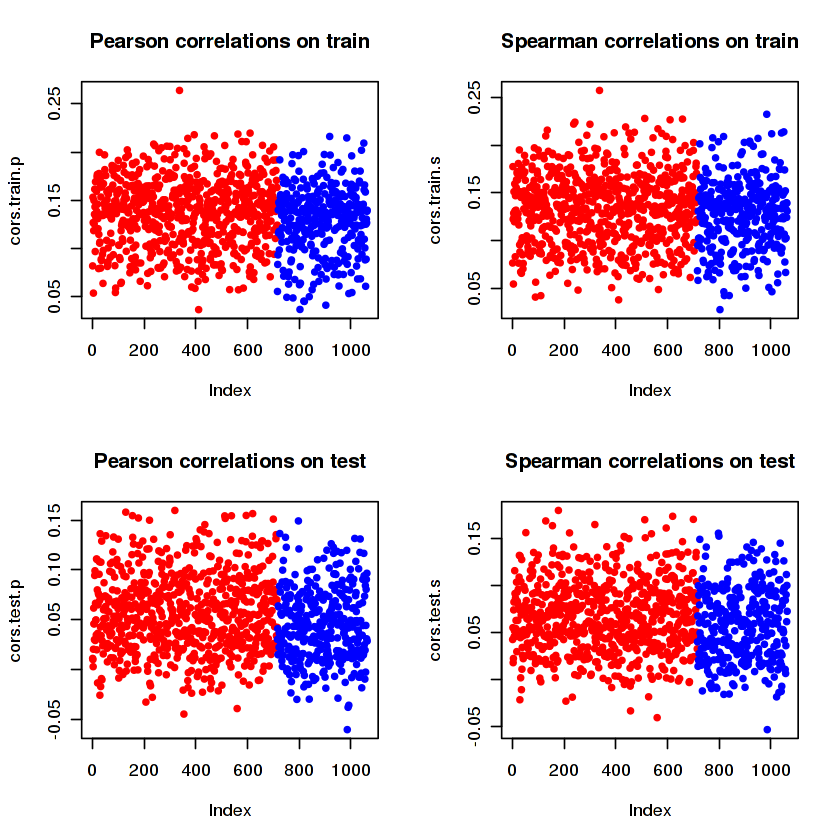

In [12]:
par(mfrow = c(2, 2))

plot(cors.train.p, main= "Pearson correlations on train", col= cols, pch= 20)
plot(cors.train.s, main= "Spearman correlations on train", col= cols, pch= 20)
plot(cors.test.p, main= "Pearson correlations on test", col= cols, pch= 20)
plot(cors.test.s, main= "Spearman correlations on test", col= cols, pch= 20)

## Plot the coefficients obtained from the model

In [13]:
## Load the heatmap library
library(pheatmap)

## Make the column annotation dataframe for the pheatmap function
ann_col <- data.frame(cell_types= cell.types)
rownames(ann_col) <- colnames(y.train)
colnames(TGL.model$B) <- colnames(y.train)

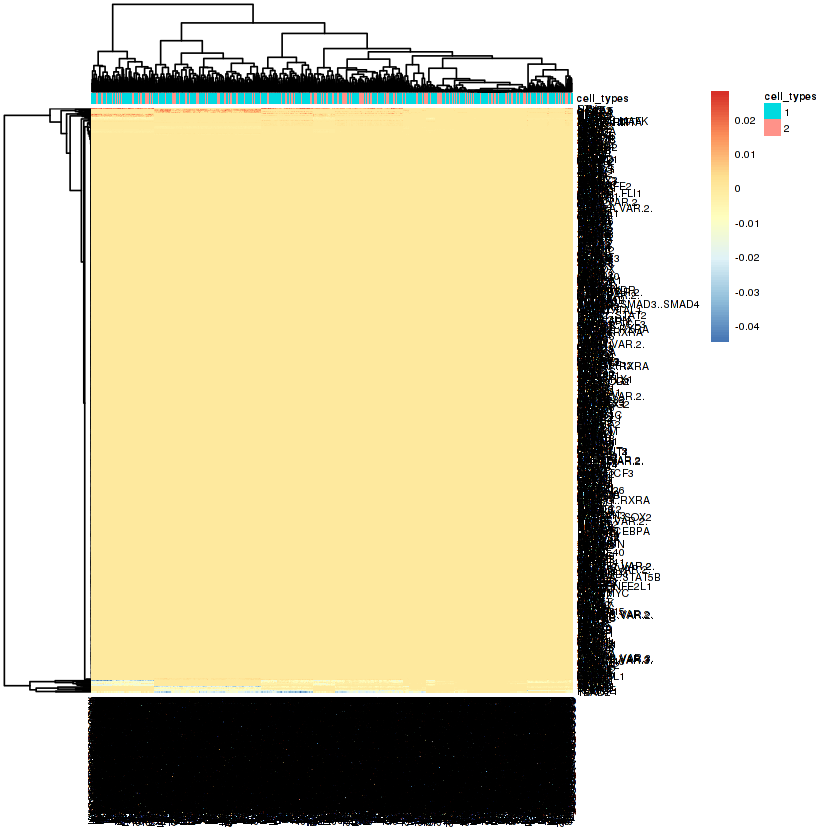

In [14]:
pheatmap(TGL.model$B, annotation_col= ann_col, fontsize= 6)

## Selecting top TFs
A threshold-dependent way of selecting the TFs that posess highest sum of coefficients across cells

In [19]:
top_TFs <- which(rowSums(abs(TGL.model$B)) > .1)
length(top_TFs)

[1] 49

In [20]:
## Make the column annotation dataframe for the pheatmap function
ann_col <- data.frame(cell_types= cell.types)
rownames(ann_col) <- colnames(y.train)
colnames(TGL.model$B) <- colnames(y.train)

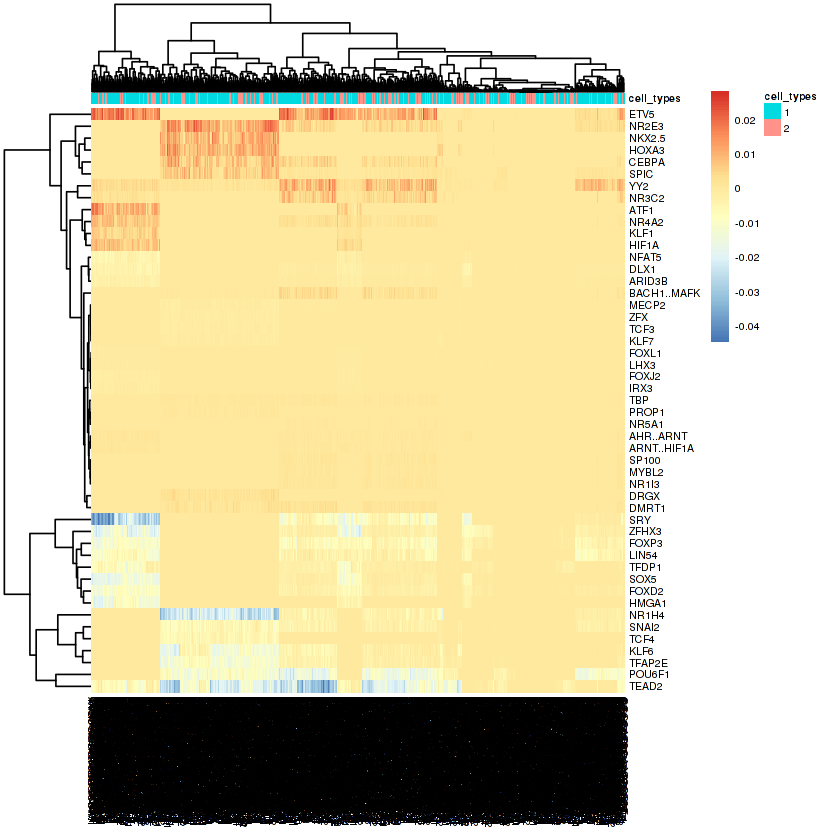

In [21]:
pheatmap(TGL.model$B[top_TFs, ], annotation_col= ann_col, fontsize= 6)

### Printing top TFs

In [22]:
print(rownames(TGL.model$B[top_TFs, ]))

 [1] "AHR..ARNT"   "ARNT..HIF1A" "BACH1..MAFK" "NFAT5"       "KLF1"       
 [6] "ETV5"        "FOXD2"       "ATF1"        "MYBL2"       "PROP1"      
[11] "SRY"         "FOXL1"       "TBP"         "SOX5"        "FOXJ2"      
[16] "CEBPA"       "NR4A2"       "ZFX"         "NKX2.5"      "YY2"        
[21] "LHX3"        "DLX1"        "TCF3"        "FOXP3"       "SPIC"       
[26] "ARID3B"      "NR2E3"       "LIN54"       "POU6F1"      "SNAI2"      
[31] "TCF4"        "NR3C2"       "TFDP1"       "DRGX"        "NR1H4"      
[36] "MECP2"       "HIF1A"       "ZFHX3"       "IRX3"        "NR1I3"      
[41] "HMGA1"       "KLF6"        "DMRT1"       "HOXA3"       "TEAD2"      
[46] "KLF7"        "TFAP2E"      "NR5A1"       "SP100"      


In [28]:
creb.idx <- which(rownames(TGL.model$B) == "CREB1")
myc.idx <- which(rownames(TGL.model$B) == "MYC")
smad2.idx <- which(rownames(TGL.model$B) == "SMAD2")
smad3.idx <- which(rownames(TGL.model$B) == "SMAD3")
print(creb.idx); print(myc.idx); print(smad2.idx); print(smad3.idx)

[1] 67
[1] 66
[1] 577
[1] 485


## Plot the coefficients for the TGF-beta related TFs

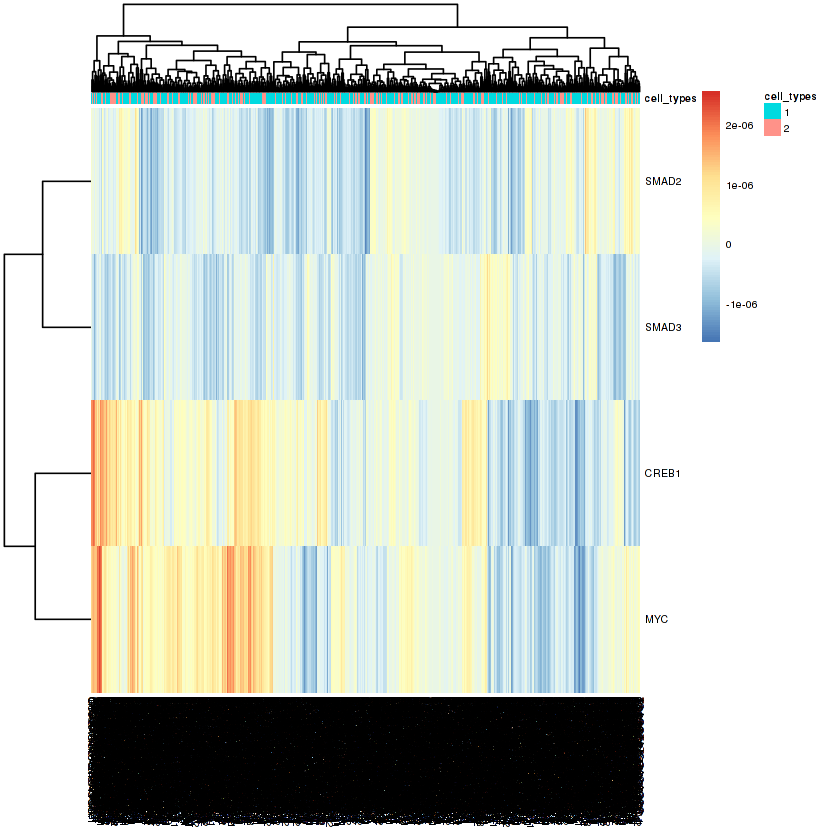

In [29]:
pheatmap(TGL.model$B[c(creb.idx, myc.idx, smad2.idx, smad3.idx), ], annotation_col= ann_col, fontsize= 6)

# Conclusion
* The model performs rather similarly between training and test datasets (measured based on prediction correlations), but the numbers are pretty low (0.15-0.25).
* Given that here we've used the static features and there's no blame on the bad quality of the features (cf, the epigenetic setup), it seems like that this is a rather difficult task of predicting these single cell gene expressions
* As the top TFs couldn't clearly separate the control vs differentiated cells, I decided to see how the TGF-beta related TFs would do the job. As shown in the last heatmap above, even them didn't deliver such division.